In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable
%matplotlib widget

import importlib
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import ExperimentClass
import tools
import math_functions as mf


In [2]:
importlib.reload(ExperimentClass)
importlib.reload(tools)
importlib.reload(mf)

##### Fonctions dont tu as besoin #####

from scipy.optimize import approx_fprime
from scipy.optimize import curve_fit

def Ek(x, A, B):
        return A * (1 - np.exp(-(x/B)))

def Ek_fit(xdata, ydata, start, stop, num, p0 = None):
    def Ek(x, A, B):
        return A * (1 - np.exp(-(x/B)))
    popt, pcov = curve_fit(Ek, xdata, ydata, p0 = p0)
    xfit = np.linspace(start, stop, num)
    yfit = Ek(xfit, popt[0], popt[1])
    return popt, pcov, xfit, yfit


def gradient_at_point(f, point, *args, **kwargs):
    def wrapped_function(params):
        combined_args = tuple(params) + args
        return f(*combined_args, **kwargs)
    
    gradient = approx_fprime(point, wrapped_function, epsilon=np.sqrt(np.finfo(float).eps))
    return gradient

def my_err(x_vect, popt, pcov, funct):
    error_vec = []
    for x in x_vect:
        point = [x] + list(popt)
        gradvec=gradient_at_point(funct, point)
        gradvec = gradvec[1:]
        variance =np.matmul(gradvec.T,np.matmul(pcov,gradvec))
        error_vec.append(np.sqrt(variance))
    return np.asarray(error_vec)


##### Pour lire le fichier .dat #####

file_path = 'C:/Users/blablabla/'
file_name = 'name_of_file.dat'

AllData = pd.read_csv(file_path + file_name, index_col=False, sep = ',')
Data = AllData.iloc[:,1:]
Time = AllData.iloc[:,0]
records = []

for i, k in enumerate(Data.keys()):
    records.append(k.replace(" ",""))

""""
Come ça tu as plus besoin de l'objet ExperimentClass "manip" 
Il te suffit de remplacer manip.Data par Data, manip.Time par Time, manip.records par records, manip.fig_folder par file_path et blablabla

""""

<module 'math_functions' from 'c:\\Users\\Orlando\\Desktop\\DREAM_repo\\math_functions.py'>

In [14]:
manip = ExperimentClass.Experiment("20240717_activation_WT4A_control_1","PSI", DataType=".csv", sep = ';')
#Intensities = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 100]
Intensities = [0, 10, 20, 30, 40, 60, 90]

In [24]:
manip.Data

,AL90,AL60,AL40,AL30,AL20,AL10,AL0
0,0.14429,0.14191,0.14886,0.15051,0.15637,0.14703,0.14227
1,0.14081,0.13971,0.14008,0.14429,0.14813,0.13916,0.13312
2,0.13440,0.13513,0.15472,0.14374,0.14978,0.14758,0.14172
3,0.13440,0.14429,0.14685,0.14355,0.14594,0.14850,0.14191
4,0.14008,0.13715,0.13953,0.14539,0.14722,0.13568,0.13733
...,...,...,...,...,...,...,...
255,0.17798,0.18750,0.19958,0.20325,0.20471,0.19739,0.17670
256,0.17395,0.17285,0.17377,0.17688,0.17670,0.17377,0.14996
257,0.15948,0.17285,0.16589,0.16846,0.16864,0.16736,0.15564
258,0.15692,0.15564,0.15436,0.16388,0.16443,0.16699,0.14209


C:\Users\Orlando\AppData\Local\Temp\ipykernel_34780\3021899370.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('inferno', len(act))


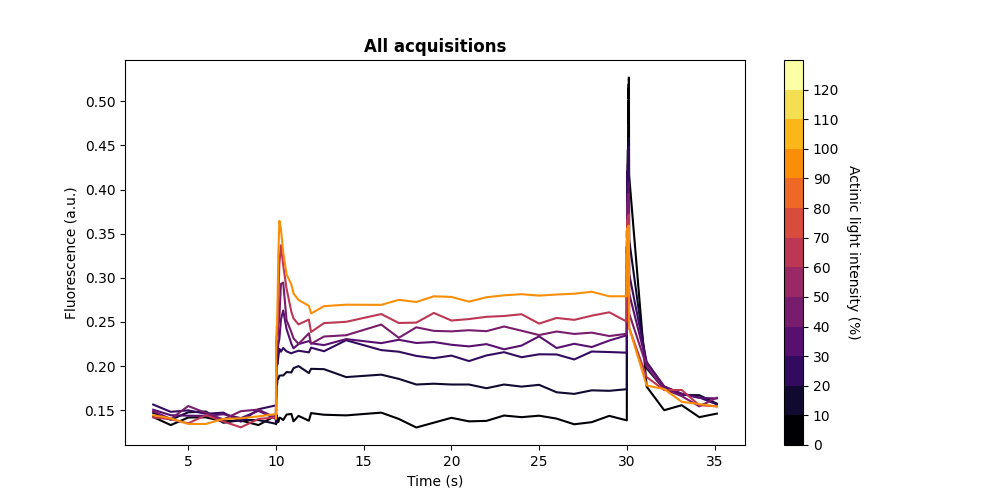

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
act = np.arange(0, 130, 10)
cmap = plt.cm.get_cmap('inferno', len(act))
for i, k in enumerate(manip.records[::-1]):
    ax.plot(manip.Time, manip.Data[k], color = cmap(tools.closest_index(act,Intensities[i])), label = f"{Intensities[i]}%")

cmap_legend = True
if cmap_legend:
# add cmap legend
    sm = ScalarMappable(norm=colors.Normalize(vmin=0, vmax=len(act)), cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm, ticks=range(len(act)), ax = ax)
    cbar.ax.set_yticklabels(act)
    cbar.ax.set_ylabel('Actinic light intensity (%)', rotation=270, labelpad=15)
else:
    ax.legend(title = "Actinic light intensity", loc = 'upper left', borderaxespad = 3)
    fig.set_figwidth(10)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Fluorescence (a.u.)')
ax.set_title('All acquisitions', fontweight = 'bold')

fig.savefig(f"{manip.fig_folder}/All_acquisitions.png", dpi=300)


In [17]:
def compute_params(Experiment_df, Intensities):
    
    t_F0 = [4, 10]                  # time interval for F0 calculation in seconds
    t_Fstat = [26, 30]              # time interval for Fstat calculation in seconds
    t_Fmax = [30.1, 30.12]       # time interval for Fmax_OJ calculation in seconds
    
    F_max = []
    F_stat = []
    F_0 = []
    phi_stat = []
    phi_0 = []
    NPQ = []
    ETR = []

    for i, k in enumerate(Experiment_df.records[::-1]):
        F_max.append(np.mean(Experiment_df.Data[k][np.where(Experiment_df.Time>= t_Fmax[0])[0][0] :np.where(Experiment_df.Time>= t_Fmax[1])[0][0]]))
        F_0.append(np.mean(Experiment_df.Data[k][np.where(Experiment_df.Time>= t_F0[0])[0][0] :np.where(Experiment_df.Time>= t_F0[1])[0][0]]))
        F_stat.append(np.mean(Experiment_df.Data[k][np.where(Experiment_df.Time>= t_Fstat[0])[0][0] :np.where(Experiment_df.Time>= t_Fstat[1])[0][0]]))
        phi_stat.append((F_max[i] - F_stat[i]) / F_max[i])
        phi_0.append((F_max[i] - F_0[i]) / F_max[i])
        NPQ.append((F_max[0] - F_max[i])/F_max[i])
        ETR.append(phi_stat[i] * Intensities[i])
        
    norm = F_max[0]
    
    F_max = list(np.array(F_max)/norm)
    F_stat = list(np.array(F_stat)/norm)
    F_0 = list(np.array(F_0)/norm)
        
    params_df = pd.DataFrame({'Record': Experiment_df.records[::-1], 'Actinic': Intensities, 'F_max': F_max, 'F_stat': F_stat,
                              'F_0': F_0, 'phi_stat': phi_stat, 'phi_0': phi_0, 'NPQ': NPQ, 'ETR': ETR})
    
    return params_df, norm
    

In [18]:
params_df, norm = compute_params(manip, Intensities)
params_df.to_csv(f"{manip.path}/params.csv", sep = ';', index = False)

In [26]:
params_df

,Record,Actinic,F_max,F_stat,F_0,phi_stat,phi_0,NPQ,ETR
0,AL0,0,1.000000,0.270035,0.271527,0.729965,0.728473,0.000000,0.000000
1,AL10,10,0.872357,0.332742,0.274020,0.618571,0.685885,0.146320,6.185708
2,AL20,20,0.858325,0.415404,0.287820,0.516029,0.664672,0.165060,10.320580
3,AL30,30,0.783099,0.436455,0.280209,0.442657,0.642179,0.276978,13.279717
4,AL40,40,0.754008,0.461426,0.286391,0.388036,0.620175,0.326245,15.521459
5,AL60,60,0.706208,0.499152,0.269150,0.293194,0.618880,0.416013,17.591634
6,AL90,90,0.680525,0.548554,0.272186,0.193925,0.600035,0.469455,17.453265


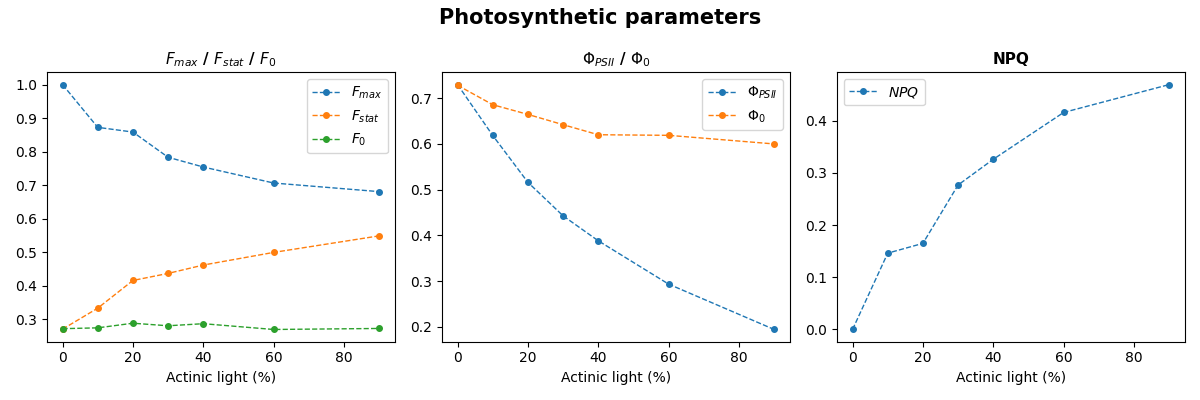

In [27]:
fig, ax = plt.subplots(1,3, figsize = (12,4))
fig.suptitle("Photosynthetic parameters", fontsize = 15, fontweight = 'bold')
line = 1
marker = 4

ax[0].plot(params_df.Actinic, params_df.F_max, 'o--', markersize = marker, linewidth = line, color = 'C0', label = '$F_{max}$')
ax[0].plot(params_df.Actinic, params_df.F_stat, 'o--', markersize = marker, linewidth = line, color = 'C1', label = '$F_{stat}$')
ax[0].plot(params_df.Actinic, params_df.F_0, 'o--', markersize = marker, linewidth = line, color = 'C2', label = '$F_{0}$')

ax[0].set_title('$F_{max}$ / $F_{stat}$ / $F_{0}$', fontsize = 11, fontweight = 'bold')

ax[1].plot(params_df.Actinic, params_df.phi_stat, 'o--', markersize = marker, linewidth = line, label = '$Φ_{PSII}$', color = 'C0')
ax[1].plot(params_df.Actinic, params_df.phi_0, 'o--', markersize = marker, linewidth = line, label = '$Φ_{0}$', color = 'C1')

ax[1].set_title('$Φ_{PSII}$ / $Φ_{0}$', fontsize = 11, fontweight = 'bold')

ax[2].plot(params_df.Actinic, params_df.NPQ, 'o--', markersize = marker, linewidth = line, label = '$NPQ$', color = 'C0')

ax[2].set_title('NPQ', fontsize = 11, fontweight = 'bold')

ax = ax.flatten()
    
[ax.set_xlabel("Actinic light (%)", fontsize = 10) for ax in ax]
[ax.legend() for ax in ax]


fig.tight_layout()

fig.savefig(f"{manip.fig_folder}/Parameters.png", dpi=300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


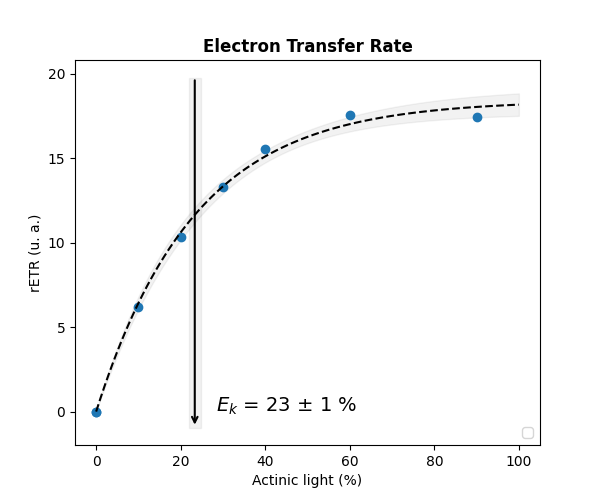

In [28]:

light = [0] + params_df.Actinic.tolist()
ETR = [0] + params_df.ETR.tolist()

fig, ax = plt.subplots(figsize = (6,5))
ax.set_title("Electron Transfer Rate", fontweight = 'bold')
ax.plot(light, ETR, 'o')
ax.legend(loc = 'lower right')


popt, pcov, xfit, yfit = tools.Ek_fit(light, ETR, 0, 100, 100, p0 = [15, 20])
err = tools.my_err(xfit, popt, pcov, mf.Ek)
ax.fill_between(xfit, yfit - 1.94*err, yfit + 1.94*err, alpha=0.05, color = 'k')
ax.plot(xfit, yfit, '--', color ='k', linewidth = 1.5)
Ek = popt[1]
Ek_err = np.sqrt(np.diag(pcov))[1]

ylim = ax.get_ylim()

ax.annotate("", xy=(Ek, ylim[0]), xytext=(Ek, ylim[1]), arrowprops=dict(arrowstyle="->", color="k", linewidth = 1.5))
ax.fill_betweenx(ylim, Ek - Ek_err, Ek + Ek_err, color="k", alpha=0.05)
ax.text(Ek + 5, 0, f"$E_k$ = {Ek:.0f} ± {Ek_err:.0f} %", fontsize = 14, color = "k")


ax.set_xlabel("Actinic light (%)")
ax.set_ylabel("rETR (u. a.)")

fig.savefig(f"{manip.fig_folder}/ETR.png", dpi=300)